In [ ]:
#NEW IDEA. PERHAPS FOR EACH FIGHT, WE LOOK AT THE CORRESPONDING POINT IN THE SPACE OF ALL FEATURES, AND THEN
#BUILD A MODEL WHERE THE TRAINING SET ONLY INVOLVES POINTS NEAR THAT POINT.
#THIS MIGHT BE MORE EFFECTIVE BECAUSE THE MOST RELEVANT FEATURES IS LIKELY TO DEPEND ON THE LOCATION
#IN THE PARAMETER SPACE.

In [1]:
#getting dependencies
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' (disables SettingWithCopyWarning)

import numpy as npy
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import random
import sklearn
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
import itertools
#this imports all of the functions from the file functions.py
from functions import *

In [2]:
ufc_fights = pd.read_csv('ufc_fights.csv',low_memory=False)

In [3]:
#importing csv fight data and saving as dataframes
ufc_fights_winner = pd.read_csv('ufc_fights.csv',low_memory=False)
ufc_fights_method = pd.read_csv('ufc_fights.csv',low_memory=False)
ufcfighterscrap =pd.read_csv('fighter_stats.csv',sep=',',low_memory=False)

In [4]:
#ages are saved as strings?? Does this affect the model? Lets fix it and see
ufc_fights_winner['fighter_age'][0]

'29.0'

In [5]:
for i in range(len(ufcfighterscrap['name'])):
    if ufcfighterscrap['name'][i]=='Xiaonan Yan':
        ufcfighterscrap['name'][i]='Yan Xiaonan'
        
for i in range(len(ufcfightscrap['fighter'])):
    if ufcfightscrap['fighter'][i]=='Xiaonan Yan':
        ufcfightscrap['fighter'][i]='Yan Xiaonan'
        
for i in range(len(ufcfightscrap['opponent'])):
    if ufcfightscrap['opponent'][i]=='Xiaonan Yan':
        ufcfightscrap['opponent'][i]='Yan Xiaonan'
    
#it gets saved as Joanne Wood for some reason
for i in range(len(ufc_fights_winner['fighter'])):
    if ufc_fights_winner['fighter'][i]=='Joanne Wood':
        ufc_fights_winner['fighter'][i]='Joanne Calderwood'
    if ufc_fights_winner['opponent'][i]=='Joanne Wood':
        ufc_fights_winner['opponent'][i]='Joanne Calderwood'
        
#it gets saved as Joanne Wood for some reason
for i in range(len(ufc_fights_winner['fighter'])):
    if ufc_fights_method['fighter'][i]=='Joanne Wood':
        ufc_fights_method['fighter'][i]='Joanne Calderwood'
    if ufc_fights_method['opponent'][i]=='Joanne Wood':
        ufc_fights_method['opponent'][i]='Joanne Calderwood'
        
#it gets saved as Joanne Wood for some reason
for i in range(len(ufc_fights['fighter'])):
    if ufc_fights['fighter'][i]=='Joanne Wood':
        ufc_fights['fighter'][i]='Joanne Calderwood'
    if ufc_fights['opponent'][i]=='Joanne Wood':
        ufc_fights['opponent'][i]='Joanne Calderwood'

In [6]:
#there are two lists of names which sometimes get scraped differently... this causes some problems which are being
#addressed in this cell. 

names_list = list(set((list(ufcfightscrap['fighter'])+list(ufcfightscrap['opponent']))))
names_list.sort()

names_list2 = list(set(ufcfighterscrap['name']))
names_list2.sort()

#Use the following two lines of code to examine names if necessary...

#for name in names_list:
    #print(name)
    
#for name in names_list2:
    #print(name)

In [7]:
#cleaning the methods column for winner prediction 
#changing anything other than 'U-DEC','M-DEC', 'KO/TKO', 'SUB', to 'bullshit'
#changing 'U-DEC','M-DEC', to 'DEC'
#(counting split decisions as bullshit)
ufc_fights_winner['method'] = clean_method_for_winner_vect(ufc_fights_winner['method'])
ufc_fights_winner['method'].unique()

array(['DEC', 'KO/TKO', 'SUB', 'bullshit'], dtype=object)

In [8]:
#cleaning the methods column for method prediction 
#changing anything other than 'U-DEC','M-DEC', 'S-DEC', 'KO/TKO', 'SUB', to 'bullshit'
#changing 'U-DEC','M-DEC', 'S-DEC', to 'DEC'
#(counting split decisions as decisions)
ufc_fights_method['method'] = clean_method_vect(ufc_fights_method['method'])
ufc_fights_method['method'].unique()

array(['DEC', 'KO/TKO', 'SUB', 'bullshit'], dtype=object)

In [9]:
#getting rid of rows with incomplete or useless data
#fights with outcome "Win" or "Loss" (no "Draw")
draw_mask=ufc_fights_winner['result'] != 'D' 
#fights where the method of victory is TKO/SUB/DEC (no split decision or DQ or Overturned or anything else like that)
method_mask_winner=(ufc_fights_winner['method']!='bullshit')
method_mask_method=(ufc_fights_method['method']!='bullshit')
#fights where age is known
age_mask=(ufc_fights_winner['fighter_age']!='unknown')&(ufc_fights_winner['opponent_age']!='unknown')
#fights where height reach is known
height_mask=(ufc_fights_winner['fighter_height']!='unknown')&(ufc_fights_winner['opponent_height']!='unknown')
reach_mask=(ufc_fights_winner['fighter_reach']!='unknown')&(ufc_fights_winner['opponent_reach']!='unknown')
#fights where number of wins is known
wins_mask=(ufc_fights_winner['fighter_wins'] != 'unknown' )& (ufc_fights_winner['opponent_wins'] != 'unknown')
#fights where both fighters have strike statistics (gets rid of UFC debuts)
strikes_mask=(ufc_fights_winner['fighter_inf_sig_strikes_attempts_avg'] != 0)&(ufc_fights_winner['opponent_inf_sig_strikes_attempts_avg'] != 0)
#includes only the fights satisfying these conditions
ufc_fights_winner=ufc_fights_winner[draw_mask&method_mask_winner&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]
ufc_fights_method=ufc_fights_method[draw_mask&method_mask_method&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]
ufc_fights=ufc_fights[draw_mask&method_mask_winner&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]

#listing all stats and making some new stats from them (differences often score higher in the learning models)
record_statistics=[u'fighter_wins', 
                   u'fighter_losses',
                   u'fighter_L5Y_wins',
                   u'fighter_L5Y_losses', 
                   u'fighter_L2Y_wins', 
                   u'fighter_L2Y_losses',
                    u'fighter_ko_wins',
                   u'fighter_ko_losses',
                   u'fighter_L5Y_ko_wins',
                   u'fighter_L5Y_ko_losses',
                   u'fighter_L2Y_ko_wins',
                    u'fighter_L2Y_ko_losses',
                   u'fighter_sub_wins',
                   u'fighter_sub_losses',
                   u'fighter_L5Y_sub_wins',
                    u'fighter_L5Y_sub_losses', 
                   u'fighter_L2Y_sub_wins', 
                   u'fighter_L2Y_sub_losses',
                   u'opponent_wins', 
                   u'opponent_losses',
                   u'opponent_L5Y_wins', 
                   u'opponent_L5Y_losses', 
                   u'opponent_L2Y_wins', 
                   u'opponent_L2Y_losses', 
                    u'opponent_ko_wins', 
                   u'opponent_ko_losses', 
                   u'opponent_L5Y_ko_wins', 
                   u'opponent_L5Y_ko_losses', 
                   u'opponent_L2Y_ko_wins',
                    u'opponent_L2Y_ko_losses', 
                   u'opponent_sub_wins', 
                   u'opponent_sub_losses',
                   u'opponent_L5Y_sub_wins', 
                    u'opponent_L5Y_sub_losses', 
                   u'opponent_L2Y_sub_wins', 
                   u'opponent_L2Y_sub_losses']

physical_stats=[ u'fighter_age',
                u'fighter_height',
                    u'fighter_reach',  
                u'opponent_age',  
                u'opponent_height',
                    u'opponent_reach']

#THERE MAY BE A PROBLEM IN AGE HEIGHT REACH TO DO WITH STRING VS FLOAT. MAKE SURE THESE ARE ALL THE CORRECT TYPE
#MAYBE WE ARE LOSING PREDICTABILITY HERE

#here is the list of all stats available (besides stance), does not include names or result
punch_statistics=[    u'fighter_inf_knockdowns_avg',
                    u'fighter_inf_pass_avg',
                    u'fighter_inf_reversals_avg',
                    u'fighter_inf_sub_attempts_avg',
                    u'fighter_inf_takedowns_landed_avg',
                    u'fighter_inf_takedowns_attempts_avg',
                    u'fighter_inf_sig_strikes_landed_avg',
                    u'fighter_inf_sig_strikes_attempts_avg',
                    u'fighter_inf_total_strikes_landed_avg',
                    u'fighter_inf_total_strikes_attempts_avg',
                    u'fighter_inf_head_strikes_landed_avg',
                    u'fighter_inf_head_strikes_attempts_avg',
                    u'fighter_inf_body_strikes_landed_avg',
                    u'fighter_inf_body_strikes_attempts_avg',
                    u'fighter_inf_leg_strikes_landed_avg',
                    u'fighter_inf_leg_strikes_attempts_avg',
                    u'fighter_inf_distance_strikes_landed_avg',
                    u'fighter_inf_distance_strikes_attempts_avg',
                    u'fighter_inf_clinch_strikes_landed_avg',
                    u'fighter_inf_clinch_strikes_attempts_avg',
                    u'fighter_inf_ground_strikes_landed_avg',
                    u'fighter_inf_ground_strikes_attempts_avg',
                
                    u'fighter_abs_knockdowns_avg',
                    u'fighter_abs_pass_avg',
                    u'fighter_abs_reversals_avg',
                    u'fighter_abs_sub_attempts_avg',
                    u'fighter_abs_takedowns_landed_avg',
                    u'fighter_abs_takedowns_attempts_avg',
                    u'fighter_abs_sig_strikes_landed_avg',
                    u'fighter_abs_sig_strikes_attempts_avg',
                    u'fighter_abs_total_strikes_landed_avg',
                    u'fighter_abs_total_strikes_attempts_avg',
                    u'fighter_abs_head_strikes_landed_avg',
                    u'fighter_abs_head_strikes_attempts_avg',
                    u'fighter_abs_body_strikes_landed_avg',
                    u'fighter_abs_body_strikes_attempts_avg',
                    u'fighter_abs_leg_strikes_landed_avg',
                    u'fighter_abs_leg_strikes_attempts_avg',
                    u'fighter_abs_distance_strikes_landed_avg',
                    u'fighter_abs_distance_strikes_attempts_avg',
                    u'fighter_abs_clinch_strikes_landed_avg',
                    u'fighter_abs_clinch_strikes_attempts_avg',
                    u'fighter_abs_ground_strikes_landed_avg',
                    u'fighter_abs_ground_strikes_attempts_avg',
                    
                    u'opponent_inf_knockdowns_avg',
                    u'opponent_inf_pass_avg',
                    u'opponent_inf_reversals_avg',
                    u'opponent_inf_sub_attempts_avg',
                    u'opponent_inf_takedowns_landed_avg',
                    u'opponent_inf_takedowns_attempts_avg',
                    u'opponent_inf_sig_strikes_landed_avg',
                    u'opponent_inf_sig_strikes_attempts_avg',
                    u'opponent_inf_total_strikes_landed_avg',
                    u'opponent_inf_total_strikes_attempts_avg',
                    u'opponent_inf_head_strikes_landed_avg',
                    u'opponent_inf_head_strikes_attempts_avg',
                    u'opponent_inf_body_strikes_landed_avg',
                    u'opponent_inf_body_strikes_attempts_avg',
                    u'opponent_inf_leg_strikes_landed_avg',
                    u'opponent_inf_leg_strikes_attempts_avg',
                    u'opponent_inf_distance_strikes_landed_avg',
                    u'opponent_inf_distance_strikes_attempts_avg',
                    u'opponent_inf_clinch_strikes_landed_avg',
                    u'opponent_inf_clinch_strikes_attempts_avg',
                    u'opponent_inf_ground_strikes_landed_avg',
                    u'opponent_inf_ground_strikes_attempts_avg',
                
                    u'opponent_abs_knockdowns_avg',
                    u'opponent_abs_pass_avg',
                    u'opponent_abs_reversals_avg',
                    u'opponent_abs_sub_attempts_avg',
                    u'opponent_abs_takedowns_landed_avg',
                    u'opponent_abs_takedowns_attempts_avg',
                    u'opponent_abs_sig_strikes_landed_avg',
                    u'opponent_abs_sig_strikes_attempts_avg',
                    u'opponent_abs_total_strikes_landed_avg',
                    u'opponent_abs_total_strikes_attempts_avg',
                    u'opponent_abs_head_strikes_landed_avg',
                    u'opponent_abs_head_strikes_attempts_avg',
                    u'opponent_abs_body_strikes_landed_avg',
                    u'opponent_abs_body_strikes_attempts_avg',
                    u'opponent_abs_leg_strikes_landed_avg',
                    u'opponent_abs_leg_strikes_attempts_avg',
                    u'opponent_abs_distance_strikes_landed_avg',
                    u'opponent_abs_distance_strikes_attempts_avg',
                    u'opponent_abs_clinch_strikes_landed_avg',
                    u'opponent_abs_clinch_strikes_attempts_avg',
                    u'opponent_abs_ground_strikes_landed_avg',
                    u'opponent_abs_ground_strikes_attempts_avg']

#here is the version of punch stats geared for comparing fighter_inf to opponent_abs
punch_statistics_alt=[    u'fighter_inf_knockdowns_avg',
                    u'fighter_inf_pass_avg',
                    u'fighter_inf_reversals_avg',
                    u'fighter_inf_sub_attempts_avg',
                    u'fighter_inf_takedowns_landed_avg',
                    u'fighter_inf_takedowns_attempts_avg',
                    u'fighter_inf_sig_strikes_landed_avg',
                    u'fighter_inf_sig_strikes_attempts_avg',
                    u'fighter_inf_total_strikes_landed_avg',
                    u'fighter_inf_total_strikes_attempts_avg',
                    u'fighter_inf_head_strikes_landed_avg',
                    u'fighter_inf_head_strikes_attempts_avg',
                    u'fighter_inf_body_strikes_landed_avg',
                    u'fighter_inf_body_strikes_attempts_avg',
                    u'fighter_inf_leg_strikes_landed_avg',
                    u'fighter_inf_leg_strikes_attempts_avg',
                    u'fighter_inf_distance_strikes_landed_avg',
                    u'fighter_inf_distance_strikes_attempts_avg',
                    u'fighter_inf_clinch_strikes_landed_avg',
                    u'fighter_inf_clinch_strikes_attempts_avg',
                    u'fighter_inf_ground_strikes_landed_avg',
                    u'fighter_inf_ground_strikes_attempts_avg',
                
                    u'fighter_abs_knockdowns_avg',
                    u'fighter_abs_pass_avg',
                    u'fighter_abs_reversals_avg',
                    u'fighter_abs_sub_attempts_avg',
                    u'fighter_abs_takedowns_landed_avg',
                    u'fighter_abs_takedowns_attempts_avg',
                    u'fighter_abs_sig_strikes_landed_avg',
                    u'fighter_abs_sig_strikes_attempts_avg',
                    u'fighter_abs_total_strikes_landed_avg',
                    u'fighter_abs_total_strikes_attempts_avg',
                    u'fighter_abs_head_strikes_landed_avg',
                    u'fighter_abs_head_strikes_attempts_avg',
                    u'fighter_abs_body_strikes_landed_avg',
                    u'fighter_abs_body_strikes_attempts_avg',
                    u'fighter_abs_leg_strikes_landed_avg',
                    u'fighter_abs_leg_strikes_attempts_avg',
                    u'fighter_abs_distance_strikes_landed_avg',
                    u'fighter_abs_distance_strikes_attempts_avg',
                    u'fighter_abs_clinch_strikes_landed_avg',
                    u'fighter_abs_clinch_strikes_attempts_avg',
                    u'fighter_abs_ground_strikes_landed_avg',
                    u'fighter_abs_ground_strikes_attempts_avg',
                
                    u'opponent_abs_knockdowns_avg',
                    u'opponent_abs_pass_avg',
                    u'opponent_abs_reversals_avg',
                    u'opponent_abs_sub_attempts_avg',
                    u'opponent_abs_takedowns_landed_avg',
                    u'opponent_abs_takedowns_attempts_avg',
                    u'opponent_abs_sig_strikes_landed_avg',
                    u'opponent_abs_sig_strikes_attempts_avg',
                    u'opponent_abs_total_strikes_landed_avg',
                    u'opponent_abs_total_strikes_attempts_avg',
                    u'opponent_abs_head_strikes_landed_avg',
                    u'opponent_abs_head_strikes_attempts_avg',
                    u'opponent_abs_body_strikes_landed_avg',
                    u'opponent_abs_body_strikes_attempts_avg',
                    u'opponent_abs_leg_strikes_landed_avg',
                    u'opponent_abs_leg_strikes_attempts_avg',
                    u'opponent_abs_distance_strikes_landed_avg',
                    u'opponent_abs_distance_strikes_attempts_avg',
                    u'opponent_abs_clinch_strikes_landed_avg',
                    u'opponent_abs_clinch_strikes_attempts_avg',
                    u'opponent_abs_ground_strikes_landed_avg',
                    u'opponent_abs_ground_strikes_attempts_avg',
                     
                     u'opponent_inf_knockdowns_avg',
                    u'opponent_inf_pass_avg',
                    u'opponent_inf_reversals_avg',
                    u'opponent_inf_sub_attempts_avg',
                    u'opponent_inf_takedowns_landed_avg',
                    u'opponent_inf_takedowns_attempts_avg',
                    u'opponent_inf_sig_strikes_landed_avg',
                    u'opponent_inf_sig_strikes_attempts_avg',
                    u'opponent_inf_total_strikes_landed_avg',
                    u'opponent_inf_total_strikes_attempts_avg',
                    u'opponent_inf_head_strikes_landed_avg',
                    u'opponent_inf_head_strikes_attempts_avg',
                    u'opponent_inf_body_strikes_landed_avg',
                    u'opponent_inf_body_strikes_attempts_avg',
                    u'opponent_inf_leg_strikes_landed_avg',
                    u'opponent_inf_leg_strikes_attempts_avg',
                    u'opponent_inf_distance_strikes_landed_avg',
                    u'opponent_inf_distance_strikes_attempts_avg',
                    u'opponent_inf_clinch_strikes_landed_avg',
                    u'opponent_inf_clinch_strikes_attempts_avg',
                    u'opponent_inf_ground_strikes_landed_avg',
                    u'opponent_inf_ground_strikes_attempts_avg']

#adding record differences to ufc_fights
record_statistics_diff = []
half_length=int(len(record_statistics)/2)
for i in range(half_length):
    ufc_fights_winner[record_statistics[i]+'_diff_2']=ufc_fights_winner[record_statistics[i]]-ufc_fights_winner[record_statistics[i+half_length]]
    ufc_fights_method[record_statistics[i]+'_diff_2']=ufc_fights_method[record_statistics[i]]-ufc_fights_method[record_statistics[i+half_length]]
    record_statistics_diff.append(record_statistics[i]+'_diff_2')
    
#lets try and improve the greedy algorithm by considering differences. Lets start by replacing height and reach by their differences
ufc_fights_winner['height_diff']=ufc_fights_winner['fighter_height'].apply(float)-ufc_fights_winner['opponent_height'].apply(float)
ufc_fights_winner['reach_diff']=ufc_fights_winner['fighter_reach'].apply(float)-ufc_fights_winner['opponent_reach'].apply(float)
ufc_fights_method['height_diff']=ufc_fights_method['fighter_height'].apply(float)-ufc_fights_method['opponent_height'].apply(float)
ufc_fights_method['reach_diff']=ufc_fights_method['fighter_reach'].apply(float)-ufc_fights_method['opponent_reach'].apply(float)


physical_stats_diff = ['fighter_age','opponent_age', 'height_diff', 'reach_diff']

#adding punch differences to ufc_fights
punch_statistics_diff = []
half_length=int(len(punch_statistics)/2)
for i in range(half_length):
    ufc_fights_method[punch_statistics[i]+'_diff_2']=ufc_fights_method[punch_statistics[i]]-ufc_fights_method[punch_statistics[i+half_length]]
    ufc_fights_winner[punch_statistics[i]+'_diff_2']=ufc_fights_winner[punch_statistics[i]]-ufc_fights_winner[punch_statistics[i+half_length]]
    punch_statistics_diff.append(punch_statistics[i]+'_diff_2')
    
possible_stats =record_statistics_diff+physical_stats_diff+punch_statistics_diff



In [12]:
ufc_fights_method['method'].unique()

array(['DEC', 'KO/TKO', 'SUB'], dtype=object)

In [13]:
ufc_fights_method['result'].unique()

array(['W', 'L'], dtype=object)

In [14]:
ufc_fights_winner['method'].unique()

array(['DEC', 'KO/TKO', 'SUB'], dtype=object)

In [15]:
ufc_fights_winner['result'].unique()

array(['W', 'L'], dtype=object)

In [16]:
ufc_fights['result'].unique()

array(['W', 'L'], dtype=object)

In [17]:
ages = ufc_fights_winner['fighter_age'].unique()
ages.sort()
ages

array(['19', '20', '21', '21.0', '22', '22.0', '23', '23.0', '24', '24.0',
       '25', '25.0', '26', '26.0', '27', '27.0', '28', '28.0', '29',
       '29.0', '30', '30.0', '31', '31.0', '32', '32.0', '33', '33.0',
       '34', '34.0', '35', '35.0', '36', '36.0', '37', '37.0', '38',
       '38.0', '39', '39.0', '40', '40.0', '41', '41.0', '42', '42.0',
       '43', '43.0', '44', '45', '46'], dtype=object)

In [18]:
ufc_fights_winner['fighter_age'] = ufc_fights_winner['fighter_age'].apply(float)
ufc_fights_winner['opponent_age'] = ufc_fights_winner['fighter_age'].apply(float)
ufc_fights_method['fighter_age'] = ufc_fights_method['fighter_age'].apply(float)
ufc_fights_method['opponent_age'] = ufc_fights_method['fighter_age'].apply(float)
ufc_fights['fighter_age'] = ufc_fights['fighter_age'].apply(float)
ufc_fights['opponent_age'] = ufc_fights['fighter_age'].apply(float)

In [19]:
ages = ufc_fights_winner['fighter_age'].unique()
ages.sort()
ages

array([19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31.,
       32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44.,
       45., 46.])

In [20]:
#this is currently the hightest scoring subset of stats to choose. It scores around .637. 
#dropped to ,.617 after I changed the age columns to be floats instead of strings... this is VERY strange...
#actually, after I changed method mask to coincide with the method prediction notebook, it dropped a whole percentage
#to .626... Why would this be?
#FIGURED IT OUT. Including split decisions in the example set drops predictions by a whole percentage. I changed the
#clean_method function to count split decisions as 'bullshit'
#This is the score to beat.

best_smallest_set=list(set(['fighter_age', 
                            'opponent_age', 
                            'reach_diff',
                            'fighter_L5Y_ko_losses_diff_2', 
                            'fighter_L5Y_wins_diff_2',
                            'fighter_L5Y_losses_diff_2', 
                            'fighter_abs_total_strikes_landed_avg_diff_2', 
                            'fighter_inf_takedowns_attempts_avg_diff_2', 
                            'fighter_abs_ground_strikes_landed_avg_diff_2'
]))

ufc_fights_df = ufc_fights_winner[['fighter_age', 
                            'opponent_age', 
                            'reach_diff',
                            'fighter_L5Y_ko_losses_diff_2', 
                            'fighter_L5Y_wins_diff_2',
                            'fighter_L5Y_losses_diff_2', 
                            'fighter_abs_total_strikes_landed_avg_diff_2', 
                            'fighter_inf_takedowns_attempts_avg_diff_2', 
                            'fighter_abs_ground_strikes_landed_avg_diff_2',]]

winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000)
X=ufc_fights_df.iloc[0:40*55].to_numpy()
y=ufc_fights_winner['result'].iloc[0:40*55]
winPredictionModel.fit(X,y)
winPredictionModel.score(X,y)

0.6177272727272727

In [21]:
#random forest does way better for picking the method!
best_stats=['fighter_ko_losses_diff_2', 'fighter_L2Y_sub_losses_diff_2']
rfc=RandomForestClassifier()
Xr=ufc_fights_method[best_stats].iloc[0:2300]
yr=ufc_fights_method['method'].iloc[0:2300]

rfc.fit(Xr,yr)
accuracy = cross_val_score(rfc,Xr,yr,cv=3).mean()
precision = cross_val_score(rfc,Xr,yr,cv=3, scoring='precision_micro').mean()
recall = cross_val_score(rfc, Xr, yr, cv=3, scoring='recall_macro').mean()
print('Accuracy: '+str(accuracy),'F1 score: '+str(precision*recall/(precision+recall)))

Accuracy: 0.5156561513157522 F1 score: 0.20793424953944925


In [22]:
#I've defined this in such a way to predict what happens when fighter1 in their day1 version fights fighter2
#in their day2 version. Meaning we could compare for example 2014 Tyron Woodley to 2019 Colby Covington
def ufc_prediction_tuple(fighter1,fighter2,day1=date.today(),day2=date.today()):
    return [fighter_age(fighter1,day1),
            fighter_age(fighter2,day2),
            fighter_reach(fighter1)-fighter_reach(fighter2),
            L5Y_ko_losses(fighter1,day1)-L5Y_ko_losses(fighter2,day2),
            L5Y_wins(fighter1,day1)-L5Y_wins(fighter2,day2),
            L5Y_losses(fighter1,day1)-L5Y_losses(fighter2,day2),
            avg_count('total_strikes_landed',fighter1,'abs',day1)-avg_count('total_strikes_landed',fighter2,'abs',day2),
            avg_count('takedowns_attempts',fighter1,'inf',day1)-avg_count('takedowns_attempts',fighter2,'inf',day2),
            avg_count('ground_strikes_landed',fighter1,'abs',day1)-avg_count('ground_strikes_landed',fighter2,'abs',day2)
        ]

def ufc_method_prediction_tuple(fighter1,fighter2,day1=date.today(),day2=date.today()):
    return [ko_losses(fighter1,day1)-ko_losses(fighter2,day2),
            sub_losses(fighter1,day1)-sub_losses(fighter2,day2)]

winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000)
X=ufc_fights_df.iloc[0:40*55].to_numpy()
y=ufc_fights_winner['result'].iloc[0:40*55]
winPredictionModel.fit(X,y)
print('coefficients'+str(winPredictionModel.coef_))
print('intercept'+str(winPredictionModel.intercept_))

best_stats=['fighter_ko_losses_diff_2', 'fighter_sub_losses_diff_2']
rfc=RandomForestClassifier()
Xr=ufc_fights_method[best_stats].iloc[0:2300].to_numpy()
yr=ufc_fights_method['method'].iloc[0:2300]
rfc.fit(Xr,yr)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

#date entered in the form 'Aug 20, 2013'
#predicts what happens if the day1 version of fighter1 fights fighter2 at their day2 version
#by default day1 and day2 are set to today if left unspecified
def ufc_predict(fighter1,fighter2,day1=date.today(), day2=date.today()):
    fighters=[fighter1,fighter2]
    random_guy=fighters[random.choice([0,1])]
    fighter1_fights=(ufcfightscrap['fighter']==fighter1).sum()
    fighter2_fights=(ufcfightscrap['fighter']==fighter2).sum()
    if fighter1_fights==0 and not fighter2_fights==0:
        print('This is '+fighter1+"'s UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.')
    elif fighter2_fights==0 and not fighter1_fights==0:
        print('This is '+fighter2+"'s UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.') 
    elif fighter1_fights==0 and fighter2_fights==0:
        print('This is both '+fighter1+"'s "+'and '+fighter2+"'s "+"UFC debuts... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.')
    else:
        try:
            print('The winner is...')
            ufc_tuple=ufc_prediction_tuple(fighter1,fighter2,day1,day2)
            ufc_method_tuple=ufc_method_prediction_tuple(fighter1,fighter2,day1,day2)
            value=winPredictionModel.predict([ufc_tuple])[0]
            result=rfc.predict([ufc_method_tuple])[0]
            if fighter1=="Jon Jones" and fighter2=="Jon Jones":
                print('Daniel Cormier')
            elif value=='W':
                print(fighter1+' by '+result)
            else:
                print(fighter2+' by '+result)
            try:
                fighter1stripped = fighter1.replace(" ","")
                fighter2stripped = fighter2.replace(" ","")
                j=random.randrange(1,5)
                img1 = mpimg.imread('images/'+str(j)+fighter1stripped+'.jpg')
                j=random.randrange(1,5)
                img2 = mpimg.imread('images/'+str(j)+fighter2stripped+'.jpg')
                fig, ax = plt.subplots(1, 2, figsize=(10,10))
                ax[0].set(title=fighter1, aspect=1, xticks=[], yticks=[])                
                imgplot = ax[0].imshow(img1)
                ax[1].set(title=fighter2, aspect=1, xticks=[], yticks=[])
                imgplot = ax[1].imshow(img2)
            except FileNotFoundError:
                print('That picture is not in the database somehow...')
        except ValueError:
            print('Fighters have incomplete data on record... or maybe there is an issue with one of the fighters names... I honestly do not know what to do with this.')
        except TypeError:
            print('Fighters have incomplete data on record... or maybe there is an issue with one of the fighters names... I honestly do not know what to do with this.')

                
                

coefficients[[-0.03429425 -0.03429425  0.0186947  -0.10857499  0.10907987 -0.04910427
  -0.07615219  0.48450442 -0.00705265]]
intercept[2.06996272]


In [23]:
# We want to predict how many times out of 10 the winning fighter would win, so we look at the values
# x*theta+b. If the value is >=0 its a win and <=0 its a loss. But how far from zero gives indication of
# how likely the outcome is.
theta = winPredictionModel.coef_
b = winPredictionModel.intercept_[0]

def presigmoid_value(fighter1,fighter2,date1,date2):
    value = 0
    tup = ufc_prediction_tuple(fighter1,fighter2,date1,date2)
    for i in range(len(tup)):
        value += tup[i]*theta[0][i]
    return value + b

def manual_prediction(fighter1,fighter2,date1,date2):
    value = presigmoid_value(fighter1,fighter2,date1,date2)
    return value>=0

In [24]:
X=ufc_fights_df.iloc[0:40*55].to_numpy()
prediction_values=[]
for i in range(40*55):
    value = 0
    tup = X[i]
    for i in range(len(tup)):
        value += tup[i]*theta[0][i]
    prediction_values.append(value + b)

(array([  6.,  17.,  62., 195., 464., 610., 505., 267.,  61.,  13.]),
 array([-2.26222532, -1.86521629, -1.46820727, -1.07119824, -0.67418921,
        -0.27718018,  0.11982884,  0.51683787,  0.9138469 ,  1.31085592,
         1.70786495]),
 <BarContainer object of 10 artists>)

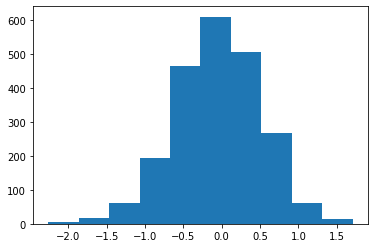

In [25]:
#shows the range of 
plt.hist(prediction_values)

In [ ]:
#checking the distribution of the average absolute values of presigmoid values
#this tells us the thresholds for approximating odds (wins out of 10)
#this takes super long... about 3 seconds per computation
prediction_average_absolute_values=[]
for i in ufc_fights_winner.index[:100]:
    try:
        f1 = ufc_fights['fighter'][i]
        f2 = ufc_fights['opponent'][i]
        date = ufc_fights['date'][i]
        value1 = presigmoid_value(f1,f2,date,date)
        value2 = presigmoid_value(f2,f1,date,date)
        prediction_average_absolute_values.append((abs(value1)+abs(value2))/2)
    except:
        continue
plt.hist(prediction_average_absolute_values)

In [44]:
ufc_fights

,date,division,fighter,opponent,result,method,fighter_wins,fighter_losses,fighter_age,fighter_height,...,opponent_abs_leg_strikes_landed_avg,opponent_abs_leg_strikes_attempts_avg,opponent_abs_distance_strikes_landed_avg,opponent_abs_distance_strikes_attempts_avg,opponent_abs_clinch_strikes_landed_avg,opponent_abs_clinch_strikes_attempts_avg,opponent_abs_ground_strikes_landed_avg,opponent_abs_ground_strikes_attempts_avg,fighter_stance,opponent_stance
0,"March 12, 2022",Light Heavyweight,Magomed Ankalaev,Thiago Santos,W,U-DEC,7.0,1.0,29.0,190.5,...,0.631579,0.942275,1.533107,4.268251,0.285229,0.387097,0.458404,0.570458,0,0
1,"March 12, 2022",Bantamweight,Song Yadong,Marlon Moraes,W,KO/TKO,7.0,1.0,24.0,172.72,...,0.523498,0.701963,2.974420,7.816776,0.285544,0.356930,1.213563,1.534801,0,0
2,"March 12, 2022",Featherweight,Sodiq Yusuff,Alex Caceres,W,U-DEC,4.0,1.0,28.0,175.26,...,0.621431,0.796103,2.361438,7.396708,0.201545,0.302318,0.285522,0.473631,0,2
3,"March 12, 2022",Light Heavyweight,Karl Roberson,Khalil Rountree Jr.,L,KO/TKO,4.0,4.0,31.0,185.42,...,0.873728,1.077199,2.956314,6.295631,0.119689,0.191502,0.502693,0.622382,2,2
4,"March 12, 2022",Lightweight,Drew Dober,Terrance McKinney,W,KO/TKO,9.0,7.0,33.0,172.72,...,0.434783,0.434783,0.434783,0.434783,0.000000,0.000000,0.000000,0.000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6249,"February 23, 2001",Middleweight,Tito Ortiz,Evan Tanner,W,KO/TKO,5.0,2.0,26.0,190.5,...,0.000000,0.000000,0.125918,1.385100,0.314795,0.377754,0.314795,0.881427,0,0
6263,"December 16, 2000",Middleweight,Chuck Liddell,Jeff Monson,W,U-DEC,2.0,1.0,30.0,187.96,...,0.000000,0.000000,0.100000,0.600000,0.000000,0.100000,0.400000,0.700000,0,0
6287,"April 14, 2000",Middleweight,Wanderlei Silva,Tito Ortiz,L,U-DEC,1.0,1.0,23.0,180.34,...,0.453782,0.630252,0.731092,1.865546,0.176471,0.378151,0.151261,0.151261,0,0
6332,"March 05, 1999",Middleweight,Chuck Liddell,Jeremy Horn,L,SUB,1.0,0.0,29.0,187.96,...,0.504202,0.705882,0.605042,1.411765,1.310924,1.815126,1.008403,1.210084,0,0


In [ ]:
#checking by hand that the accuracy of the manual predictions are the same as the accuracy 
#getting .61 after 100 iterations but .56 after 200 iterations (need longer run)
#.53 after 400 iterations (need longer run)
#.545 for 100 iterations (starting at number 400 so [400:500])
#.62 for 500 iterations (starting at number 500 so [500:1000])
#.607 for 1000 iterations (starting at number 1000 so [1000:2000])
# for 1000 iterations (starting at number 2000 so [2000:3000])


#given by python's model score (around .61 at time of writing... Mar 18 2022)
#takes forever... about 3 seconds per computation
real_values = ufc_fights['result']
is_model_correct=[]
index=0
for i in ufc_fights.index[2000:3000]:
    try:
        index+=1
        f1 = ufc_fights['fighter'][i]
        f2 = ufc_fights['opponent'][i]
        date = ufc_fights['date'][i]
        if (manual_prediction(f1,f2,date,date)):
            my_pred = 'W'
        else:
            my_pred = 'L'
        print(f1,f2,my_pred,str(real_values[i]))
        if (my_pred==real_values[i]):
            is_model_correct.append(1)
        else:
            is_model_correct.append(0)
    except:
        continue
    if index>0 and index%10==0:
        manual_accuracy = sum(is_model_correct)/len(is_model_correct)
        print('The accuracy of the model is computed as: '+str(manual_accuracy)+' after '+str(index)+' iterations')

Patrick Cote Joshua Burkman L W
Francisco Trinaldo Chad Laprise W W
Tony Sims Olivier Aubin-Mercier L L
Valerie Letourneau Maryna Moroz W W
Frankie Perez Sam Stout L W
Yves Jabouin Felipe Arantes L L
Nikita Krylov Marcos Rogerio de Lima L W
Shane Campbell Elias Silverio L W
Glover Teixeira Ovince Saint Preux L W
Sam Alvey Derek Brunson L L
The accuracy of the model is computed as: 0.5 after 10 iterations
Jared Rosholt Timothy Johnson W W
Amanda Nunes Sara McMann W W
Chris Camozzi Tom Watson W W
Willie Gates Dustin Ortiz L L
Bethe Correia Ronda Rousey L L
Rogerio Nogueira Mauricio Rua L L
Antonio Rodrigo Nogueira Stefan Struve L L
Soa Palelei Antonio Silva W L
Demian Maia Neil Magny L W
Rafael Cavalcante Patrick Cummins L L
The accuracy of the model is computed as: 0.65 after 20 iterations
Nordine Taleb Warlley Alves W L
Iuri Alcantara Leandro Issa L W
Vitor Miranda Clint Hester L W
Hugo Viana Guido Cannetti L L
Renan Barao TJ Dillashaw W L
Jessica Eye Miesha Tate L L
Paul Felder Edson 

Jon Jones Daniel Cormier W W
Myles Jury Donald Cerrone W L
Brad Tavares Nate Marquardt W W
Kyoji Horiguchi Louis Gaudinot W W
Paul Felder Danny Castillo L W
Rodrigo Damm Evan Dunham L L
Lyoto Machida CB Dollaway L W
Renan Barao Mitch Gagnon W W
Patrick Cummins Antonio Carlos Junior W W
Rashid Magomedov Elias Silverio L W
The accuracy of the model is computed as: 0.589041095890411 after 220 iterations
Erick Silva Mike Rhodes W W
Marcos Rogerio de Lima Igor Pokrajac L W
Hacran Dias Darren Elkins L W
Leandro Issa Yuta Sasaki L W
Stipe Miocic Junior Dos Santos W L
Rafael Dos Anjos Nate Diaz W W
Stefan Struve Alistair Overeem W L
Gabriel Gonzaga Matt Mitrione L L
Joe Riggs Ben Saunders L L
Drew Dober Jamie Varner W W
The accuracy of the model is computed as: 0.5851528384279476 after 230 iterations
Charles Oliveira Jeremy Stephens W W
Joe Proctor Yancy Medeiros W L
Gilbert Melendez Anthony Pettis L L
Travis Browne Brendan Schaub W W
Anthony Hamilton Todd Duffee W L
Abel Trujillo Tony Ferguso

Seth Baczynski Thiago Alves W L
Jorge Masvidal Pat Healy W W
Tim Kennedy Michael Bisping L W
Kyle Noke Patrick Cote W L
Akira Corassani Dustin Poirier L L
The accuracy of the model is computed as: 0.5871121718377088 after 420 iterations
Sam Stout KJ Noons W L
George Roop Dustin Kimura L W
Antonio Rodrigo Nogueira Roy Nelson L L
Clay Guida Tatsuya Kawajiri L W
John Howard Ryan LaFlare L L
Beneil Dariush Ramsey Nijem L L
Daniel Omielanczuk Jared Rosholt L L
Thales Leites Trevor Smith W W
Mauricio Rua Dan Henderson L L
Cezar Ferreira CB Dollaway W L
The accuracy of the model is computed as: 0.5874125874125874 after 430 iterations
Gian Villante Fabio Maldonado W L
Michel Prazeres Mairbek Taisumov L W
Steven Siler Rony Jason W L
Thiago Santos Ronny Markes W W
Scott Jorgensen Jussier Formiga W L
Robbie Lawler Johny Hendricks L L
Carlos Condit Tyron Woodley W L
Diego Sanchez Myles Jury L L
Hector Lombard Jake Shields L W
Ovince Saint Preux Nikita Krylov W W
The accuracy of the model is comput

The winner is...
Thiago Santos by KO/TKO
The winner is...
Song Yadong by DEC
The winner is...
Alex Caceres by DEC
The winner is...
Karl Roberson by DEC
The winner is...
Terrance McKinney by DEC
The winner is...
Bruno Silva by DEC
The winner is...
JJ Aldrich by DEC
The winner is...
Kamuela Kirk by DEC
The winner is...
Sabina Mazo by DEC
The winner is...
Dalcha Lungiambula by DEC


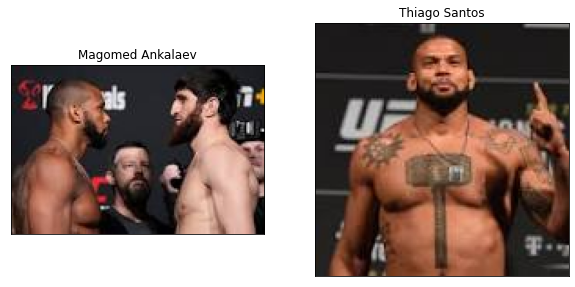

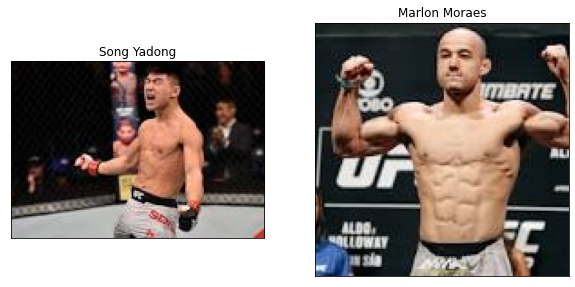

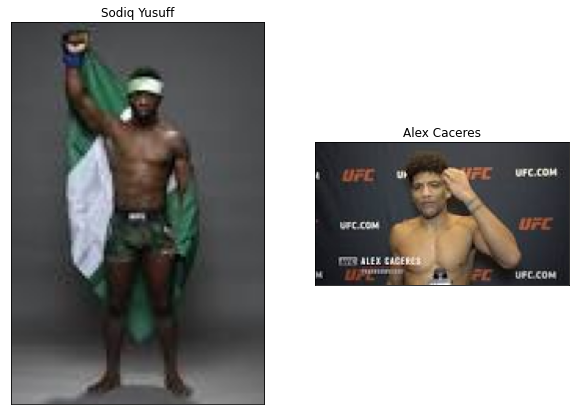

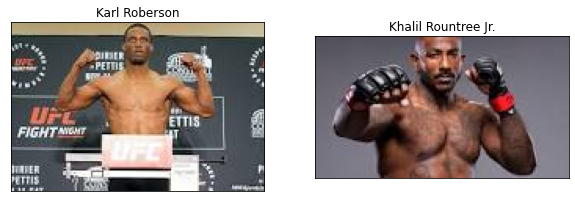

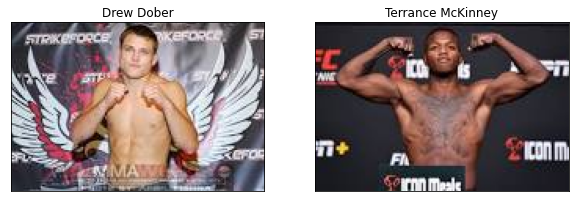

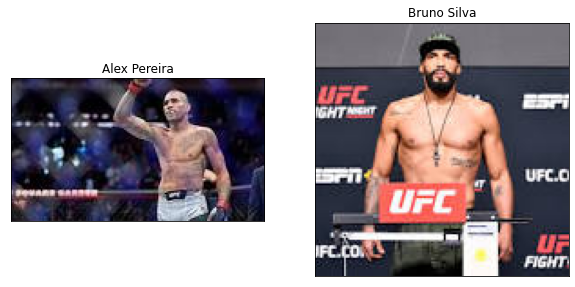

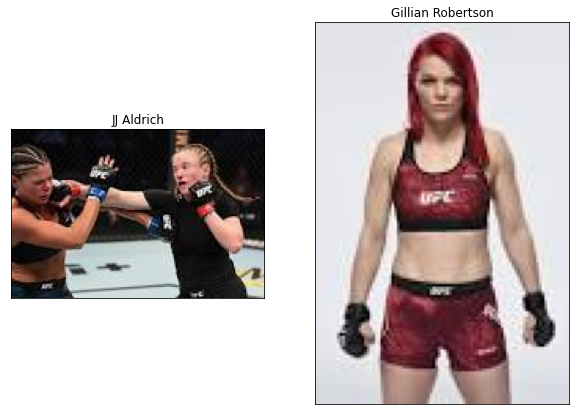

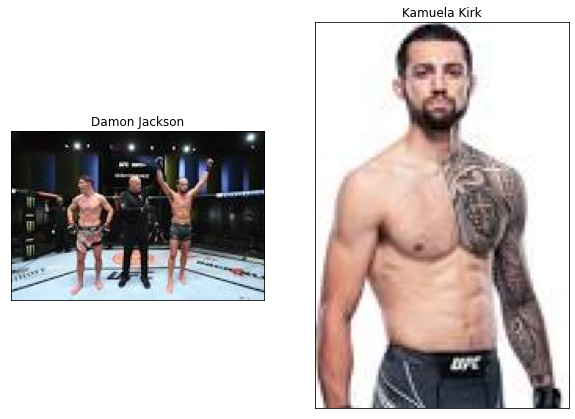

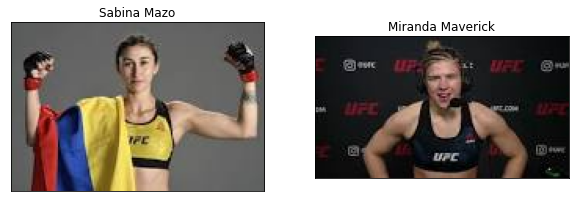

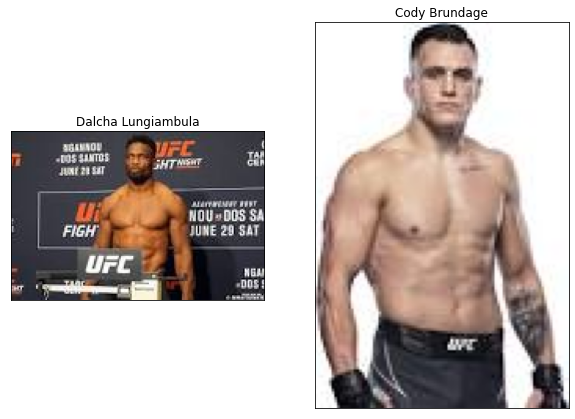

In [43]:
#making sure the manual model predictions are as expected
#takes forever... about 3 seconds per computation
real_values = ufc_fights['result']
is_model_correct=[]

for i in ufc_fights.index[:10]:
    try:
        f1 = ufc_fights['fighter'][i]
        f2 = ufc_fights['opponent'][i]
        date = ufc_fights['date'][i]
        ufc_predict(f1,f2,date,date)
    except:
        print('this fight didnt compute right')

In [53]:
def give_odds(fighter1,fighter2,date1,date2):
    value = presigmoid_value(fighter1,fighter2,date1,date2)
    if value>=0:
        winner=fighter1
    else:
        winner=fighter2
    value2 = presigmoid_value(fighter2,fighter1,date2,date1)
    abs_value = (abs(value)+abs(value2))/2
    if abs_value >=0 and abs_value <=.4:
        print(winner+" wins 6 out of 10 times.")
    elif abs_value >=.4 and abs_value <=.65:
        print(winner+" wins 7 out of 10 times.")
    elif abs_value >=.65 and abs_value <=.8:
        print(winner+" wins 8 out of 10 times.")
    elif abs_value >=.8 and abs_value <=1.3:
        print(winner+" wins 9 out of 10 times.")
    elif abs_value >=1.3:
        print(winner+" wins 10 out of 10 times.")

In [39]:
#example of finding pre sigmoid value for a fight
b = winPredictionModel.intercept_[0]
value = 0
tup = ufc_prediction_tuple('Jorge Masvidal','Colby Covington', 'March 5, 2022', 'March 5, 2022')
for i in range(len(tup)):
    value += tup[i]*theta[0][i]
value+b

In [54]:
give_odds('Colby Covington', 'Jorge Masvidal', 'March 5, 2022', 'March 5, 2022')

Colby Covington wins 7 out of 10 times.


In [56]:
#something is serisouly wrong with the model if colby vs jorge gets .126 and jorge vs colby gets -.855
#this needs to be fixed...
v1=presigmoid_value('Colby Covington','Jorge Masvidal', 'March 5, 2022', 'March 5, 2022')
v2=presigmoid_value('Jorge Masvidal','Colby Covington', 'March 5, 2022', 'March 5, 2022')
print(v1)
print(v2)
print(abs(v1)+abs(v2)/2)

0.12604757663789878
-0.8559055177652279
0.5540003355205128


In [50]:
presigmoid_value('Jorge Masvidal','Colby Covington', 'March 5, 2022', 'March 5, 2022')

-0.8559055177652279

In [ ]:
ufc_predict('Colby Covington','Jorge Masvidal', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Rafael Dos Anjos','Renato Moicano', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
presigmoid_value('Rafael Dos Anjos','Renato Moicano', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
presigmoid_value('Renato Moicano','Rafael Dos Anjos', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Edson Barboza','Bryce Mitchell', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Edson Barboza','Bryce Mitchell', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Bryce Mitchell', 'Edson Barboza', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Kevin Holland','Alex Oliveira', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
presigmoid_value('Kevin Holland','Alex Oliveira', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
presigmoid_value('Alex Oliveira', 'Kevin Holland','March 5, 2022', 'March 5, 2022',)

In [ ]:
#there must be an issue with the say Spivak's name is scraped. look into this... fix needed
ufc_predict('Sergey Spivak','Greg Hardy', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Jalin Turner','Jamie Mullarkey', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
fighter_height('Yan Xiaonan')

In [ ]:
#issue with unknown reach/height... fix needed
ufc_predict('Marina Rodriguez','Yan Xiaonan', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Nicolae Negumereanu','Kennedy Nzechukwu', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Maryna Moroz','Mariya Agapova', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Umar Nurmagomedov','Brian Kelleher', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Tim Elliott','Tagir Ulanbekov', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
#Must be an issue with michal's name in scraping
ufc_predict('Dustin Jacoby','Michał Oleksiejczuk', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Thiago Santos','Magomed Ankalaev', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Marlon Moraes','Song Yadong', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Sodiq Yusuff','Alex Caceres', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Khalil Rountree Jr.','Karl Roberson', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Drew Dober','Terrance McKinney', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Alex Pereira','Bruno Silva', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Matthew Semelsberger','AJ Fletcher', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('JJ Aldrich','Gillian Robertson', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Trevin Jones','Javid Basharat', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Damon Jackson','Kamuela Kirk', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Sabina Mazo','Miranda Maverick', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Dalcha Lungiambula','Cody Brundage', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Kris Moutinho','Guido Cannetti', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Tafon Nchukwi','Azamat Murzakanov', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict(ufc_fights['fighter'][i],ufc_fights['opponent'][i],ufc_fights['date'][i],ufc_fights['date'][i])

In [ ]:
ufc_predict('Alexander Volkov','Tom Aspinall','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Arnold Allen','Dan Hooker','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Paddy Pimblett','Rodrigo Vargas','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Gunnar Nelson','Takashi Sato','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Molly McCann','Luana Carolina','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Jai Herbert','Ilia Topuria','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Mike Grundy', 'Makwan Amirkhani', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Shamil Abdurakhimov', 'Sergei Pavlovich', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Nikita Krylov', 'Paul Craig', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Jack Shore', 'Timur Valiev', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Cory McKenna', 'Elise Reed', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Nathaniel Wood', 'Vince Morales', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Muhammad Mokaev', 'Cody Durden', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Cody Garbrandt','Raphael Assuncao', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Jon Jones','Jon Jones', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Francis Ngannou','Francis Ngannou', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Randy Couture','Francis Ngannou', 'March 5, 2012', 'March 5, 2022')

In [ ]:
ufc_predict('Roy Nelson','Anthony Johnson', 'March 5, 2012', 'March 5, 2022')